# LlamaParse JSON Mode + Advanced RAG with `LlamaParseJsonNodeParser`

<a href="https://colab.research.google.com/github/run-llama/llama_parse/blob/main/examples/demo_json_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows you how to use LlamaParse JSON mode with LlamaIndex to build a simple recursive retrieval RAG pipeline using `LlamaParseJsonNodeParser`.

Using JSON mode gives you back a list of json dictionaries, which contains both text, tables, and images. `LlamaParseJsonNodeParser` enables us to parse Json nodes with formalizing indexing nodes with enriched information from Json.

Note: Please ensure installing the latest `llama-index>=0.10.20` and `llama-index-core>=0.10.20.post2`

## Setup

Define imports, env variables, global LLM/embedding models.

In [ ]:
%pip install llama-index
%pip install llama-index-core
%pip install llama-index-llms-anthropic llama-index-multi-modal-llms-anthropic
%pip install llama-index-embeddings-huggingface
%pip install llama-parse

In [ ]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
import nest_asyncio

nest_asyncio.apply()

import os

# API access to llama-cloud
os.environ["LLAMA_CLOUD_API_KEY"] = "llx-"

# Using Openai API for embeddings/LLMs
os.environ["OPENAI_API_KEY"] = "sk-"

### Download raw PDF

In [ ]:
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/10q/uber_10q_march_2022.pdf' -O './uber_10q_march_2022.pdf'

## Parsing raw pdf using LlamaParse for getting Json Structured Output 

In [ ]:
from llama_parse import LlamaParse

parser = LlamaParse(verbose=True)
json_objs = parser.get_json_result("./uber_10q_march_2022.pdf")
json_list = json_objs[0]["pages"]

/Users/haotianzhang/llama_parser/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Started parsing the file under job_id 934890ac-ca35-4ef4-a859-04fa9e45d464


### Output one page Json output for example

In [ ]:
for page in json_list:
    print(page)
    break

{'page': 1, 'text': "                                                                                         UNITED STATES\n                                                    SECURITIES AND EXCHANGE COMMISSION\n                                                                                         Washington, D.C. 20549\n                                                                        ____________________________________________\n                                                                                               FORM 10-Q\n                                                                        ____________________________________________\n(Mark One)\n☒ QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n                                                                            For the quarterly period ended March 31, 2022\n                                                                                                          

### Init documents for each page from the Json output

In [ ]:
from llama_index.core.schema import BaseNode, TextNode, Document

documents = []
for _, page in enumerate(json_list):
    documents.append(
        Document(
            text=page.get("text"),
            metadata=page,
        )
    )

for doc in documents:
    print(doc.id_, doc.text.strip()[:10], doc.metadata)
    break

a8f98527-3025-48a7-a622-5a6bf650205b UNITED STA {'page': 1, 'text': "                                                                                         UNITED STATES\n                                                    SECURITIES AND EXCHANGE COMMISSION\n                                                                                         Washington, D.C. 20549\n                                                                        ____________________________________________\n                                                                                               FORM 10-Q\n                                                                        ____________________________________________\n(Mark One)\n☒ QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n                                                                            For the quarterly period ended March 31, 2022\n                                                          

In [ ]:
print(len(documents))

106


## Parsing Json Nodes using `LlamaParseJsonNodeParser` for each page
It will generate index node (basic text nodes and table summary nodes) and reference nodes (the real table content nodes with full table markdown)

In [ ]:
from llama_index.core.node_parser import LlamaParseJsonNodeParser
from llama_index.llms.openai import OpenAI

node_parser = LlamaParseJsonNodeParser(
    llm=OpenAI(model="gpt-3.5-turbo"), num_workers=16, include_metadata=True
)
nodes = node_parser.get_nodes_from_documents(documents)
base_nodes, objects = node_parser.get_nodes_and_objects(nodes)

## Build Recursive Retrieval index/retriever using the Json Nodes parsed using `LlamaParseJsonNodeParser`

In [ ]:
from llama_index.core import VectorStoreIndex


recursive_index = VectorStoreIndex(nodes=base_nodes + objects)
recursive_query_engine = recursive_index.as_query_engine(
    similarity_top_k=5, verbose=True
)
res = recursive_query_engine.query(
    "what is UBER Short-term insurance reserves reported in 2022"
)

Retrieval entering id_page_34_49fc3181-de8c-4b21-9684-7d05371eaa20_2_table: TextNode
Retrieving from object TextNode with query what is UBER Short-term insurance reserves reported in 2022
Retrieval entering id_page_5_e055198c-17fc-40fe-8f20-468600084935_3_table: TextNode
Retrieving from object TextNode with query what is UBER Short-term insurance reserves reported in 2022
Retrieval entering id_page_6_64d823e4-ccc5-4200-b6b8-080ab5c5333f_0_table: TextNode
Retrieving from object TextNode with query what is UBER Short-term insurance reserves reported in 2022


In [ ]:
print(res)

UBER Short-term insurance reserves reported in 2022 were $1,415.


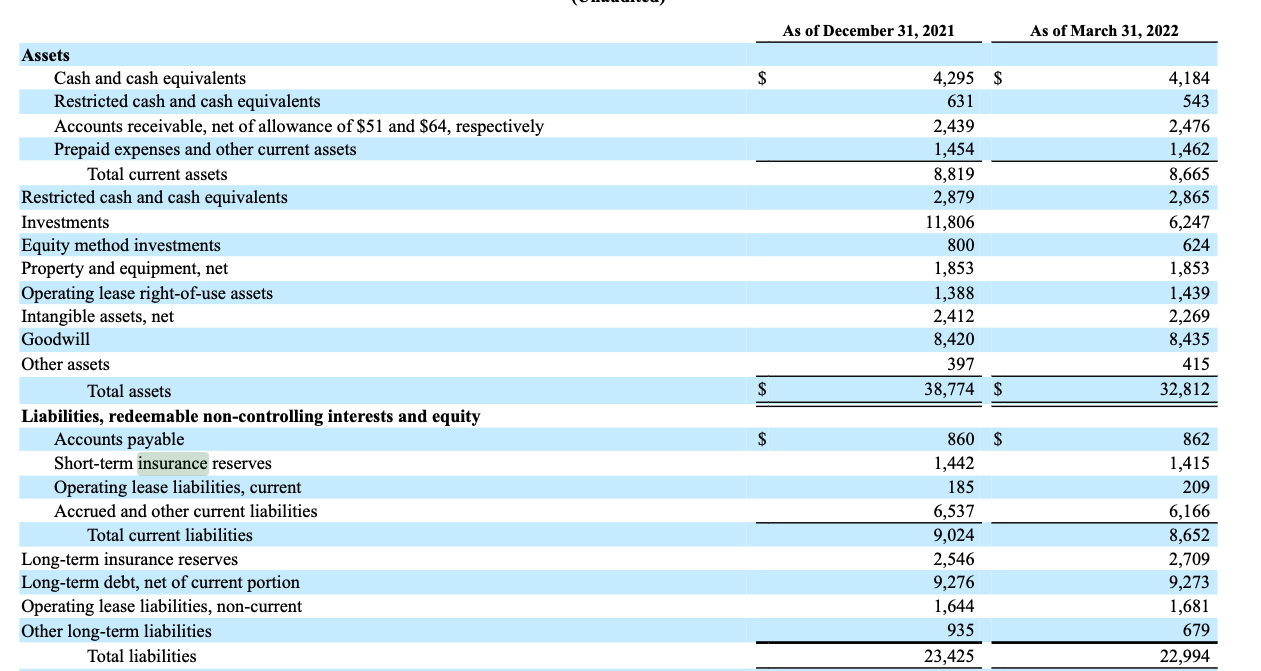

In [ ]:
res = recursive_query_engine.query(
    "what is Comprehensive income (loss) attributable to Uber reported in 2021"
)

Retrieval entering id_page_7_7bec92c4-3b76-4843-9d9c-f46e5021a156_0_table: TextNode
Retrieving from object TextNode with query what is Comprehensive income (loss) attributable to Uber reported in 2021
Retrieval entering id_page_38_14de6a4f-1fa4-465a-b9f8-5b1aa1cd90b5_0_table: TextNode
Retrieving from object TextNode with query what is Comprehensive income (loss) attributable to Uber reported in 2021
Retrieval entering id_page_6_64d823e4-ccc5-4200-b6b8-080ab5c5333f_0_table: TextNode
Retrieving from object TextNode with query what is Comprehensive income (loss) attributable to Uber reported in 2021
Retrieval entering id_page_38_14de6a4f-1fa4-465a-b9f8-5b1aa1cd90b5_1_table: TextNode
Retrieving from object TextNode with query what is Comprehensive income (loss) attributable to Uber reported in 2021


In [ ]:
print(res)

$1,081


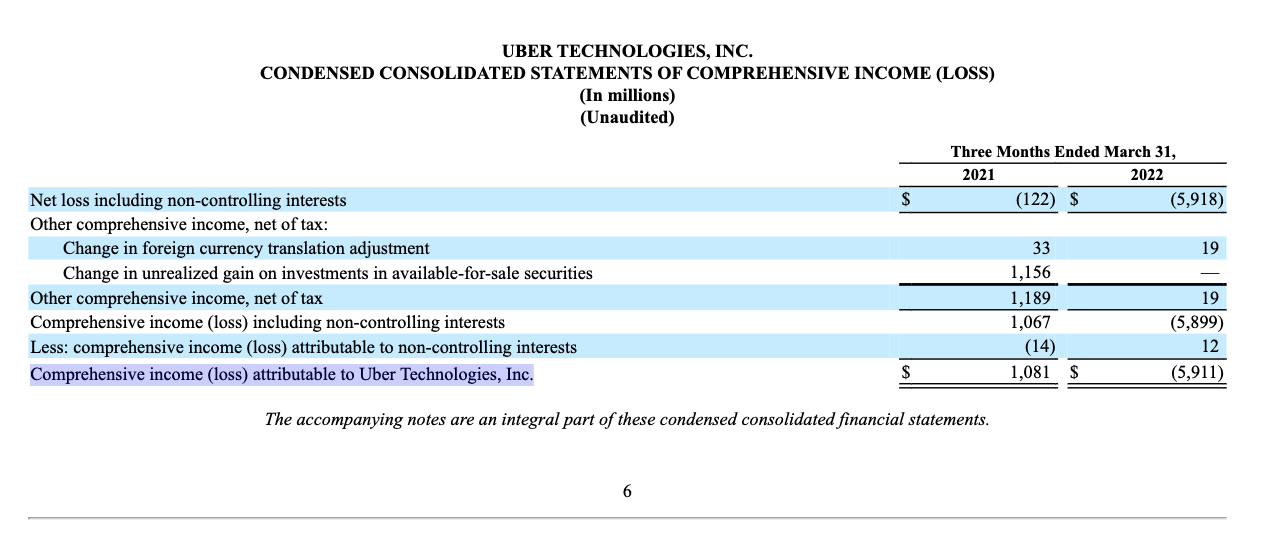